# Some examples of do-calculus

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
from IPython.display import display, Math, Latex, HTML

import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb

## S. Tikka and J. Karvanen, 2016 [CRAN]

In [2]:
bn = gum.fastBN("w->x->z->y;w->z")

bn.cpt("w")[:] = [0.7,0.3]

bn.cpt("x")[:] = [[0.4,0.6],[0.3,0.7]]

bn.cpt("z")[{'w':0,'x':0}]=[0.2,0.8]
bn.cpt("z")[{'w':0,'x':1}]=[0.1,0.9]
bn.cpt("z")[{'w':1,'x':0}]=[0.9,0.1]
bn.cpt("z")[{'w':1,'x':1}]=[0.5,0.5]

bn.cpt("y")[:] = [[0.1,0.9],[0.8,0.2]]


d = csl.CausalModel(bn, [("lat1", ["x","y"])])
#csl.causalImpact(d,"y",{"x":0})
cslnb.showCausalImpact(d,"y","x",values={"x":0})
cslnb.showCausalImpact(d,"y","x",values={"x":1})



Since we have the formula, let us compute by hand this intervention :

In [3]:
(((bn.cpt("x") * bn.cpt("y")).sumOut(["x"]) * bn.cpt("w") * bn.cpt("z")).sumOut(["z", "w"])).putFirst("y")

(pyagrum.Tensor@0x600000cbc0e0) 
      ||  y                |
x     ||0        |1        |
------||---------|---------|
0     || 0.5130  | 0.4870  |
1     || 0.6460  | 0.3540  |

In [4]:
bn = gum.fastBN("Z1->X->Z2->Y")
d=csl.CausalModel(bn,[("L1",["Z1","X"]),
                      ("L2",["Z1","Z2"]),
                      ("L3",["Z1","Y"]),
                      ("L4",["Y","X"])],
                  True)
cslnb.showCausalImpact(d,"Y","X",values={"X":1})

## Front door

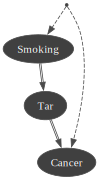

In [5]:
modele4 = gum.BayesNet()
modele4.add(gum.LabelizedVariable("Smoking"))
modele4.add(gum.LabelizedVariable("Cancer"))
modele4.add(gum.LabelizedVariable("Tar"))

modele4.addArc(0,2)
modele4.addArc(2,1)
modele4.addArc(0,1)

#Smoking
modele4.cpt(0)[:]=[0.5, 0.5]

#Tar
modele4.cpt(2)[{"Smoking":0}] = [0.4, 0.6]
modele4.cpt(2)[{"Smoking":1}] = [0.3, 0.6]

#Cancer
modele4.cpt(1)[{'Smoking':0,'Tar':0}]=[0.1,0.9]   #No Drug, Male -> healed in 0.8 of cases
modele4.cpt(1)[{'Smoking':0,'Tar':1}]=[0.15,0.85] #No Drug, Female -> healed in 0.4 of cases
modele4.cpt(1)[{'Smoking':1,'Tar':0}]=[0.2,0.8]   #Drug, Male -> healed 0.7 of cases 
modele4.cpt(1)[{'Smoking':1,'Tar':1}]=[0.25,0.75]

d4 = csl.CausalModel(modele4, [("Genotype", ["Smoking","Cancer"])],False)
cslnb.showCausalModel(d4)

In [6]:
try: 
    a = csl.doCalculusWithObservation (d4,"Cancer", {"Smoking"})
except csl.HedgeException as h: 
    print (h.message)

In [7]:
display(Math(a.toLatex()))

<IPython.core.display.Math object>

In [8]:
try: 
    adjj = a.eval()
except csl.UnidentifiableException as u: 
    print (u.message)
    
print (adjj)



      ||  Cancer           |
Smokin||0        |1        |
------||---------|---------|
0     || 0.1774  | 0.8226  |
1     || 0.1626  | 0.7374  |



In [9]:
formula, adj, exp = csl.causalImpact(d4, "Cancer", "Smoking",values={"Smoking":0})

In [10]:
display(Math(formula.toLatex()))
adj

<IPython.core.display.Math object>

(pyagrum.Tensor@0x600000ccece0) 
  Cancer           |
0        |1        |
---------|---------|
 0.1774  | 0.8226  |

  ## Last example from R 

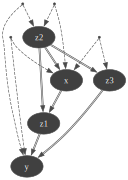

In [11]:
m = gum.fastBN("z2->x->z1->y;z2->z1;z2->z3->y")

m.cpt("z2") [:] = [0.5, 0.5]
m.cpt("x") [:] = [[0.4,0.6], #z2=0
                  [0.4,0.6]] #z2=1
m.cpt("z3") [:] = [[0.3,0.7], #z2=0
                   [0.3,0.7]] #z2=1
m.cpt("z1")[{"z2":0, "x":0}]= [0.2, 0.8]
m.cpt("z1")[{"z2":0, "x":1}]= [0.25, 0.75]
m.cpt("z1")[{"z2":1, "x":0}]= [0.1, 0.9]
m.cpt("z1")[{"z2":1, "x":1}]= [0.15, 0.85]

m.cpt("y")[{"z1":0,"z3":0}]= [0.5,0.5]
m.cpt("y")[{"z1":0,"z3":1}]= [0.45,0.55]
m.cpt("y")[{"z1":1,"z3":0}]= [0.4,0.6]
m.cpt("y")[{"z1":1,"z3":1}]= [0.35,0.65]


d = csl.CausalModel(m, [("X-Z2",["x","z2"]), 
                        ("X-Z3",["x","z3"]), 
                        ("X-Y",["x","y"]), 
                        ("Y-Z2",["y","z2"])],
                    True)

cslnb.showCausalModel(d)

In [12]:
try:
    formula,result,msg = csl.causalImpact(d,on={"y","z2","z1","z3"},doing={"x"})
except csl.HedgeException as h:
    print (h.message)
    
print(msg)
display(Math(formula.toLatex()))

Do-calculus computations


<IPython.core.display.Math object>

In [13]:
# computation for this formula directly in pyAgrum
f1=m.cpt("x")*m.cpt("z2")*m.cpt("z3")*m.cpt("y")
f2=f1.sumOut(["x"])
f3=f1.sumOut(["x","y"])
f4=f2/f3
pyResult=m.cpt("z3")*m.cpt("z1")*m.cpt("z2")*f4

In [14]:
# computation for this formula directly by creating the causal AST
a = csl.ASTposteriorProba(m,{"z1"},{"x","z2"})
b= csl.ASTposteriorProba(m,{"y","z3"},{"x","z1","z2"})
c = csl.ASTjointProba(["x","z2"])
correct = csl.ASTmult(a,csl.ASTsum(["x"],csl.ASTmult(b,c)))

print("According to [ref], the result should be :")
display(Math(correct.toLatex()))

According to [ref], the result should be :


<IPython.core.display.Math object>

In [15]:
# computation for that formula
ie=gum.LazyPropagation(m)
refResult=(ie.evidenceJointImpact(["y","z3"],["x","z1","z2"])*
     ie.evidenceJointImpact(["x","z2"],[])
    ).sumOut(["x"])* m.cpt("z1")


In [16]:
print("Maximum error between these 3 versions : {}".format(max((refResult-pyResult).abs().max(),
                                                               (refResult-result).abs().max(),
                                                               (pyResult-result).new_abs().max())))

Maximum error between these 3 versions : 5.551115123125783e-17


## Unidentifiabilty


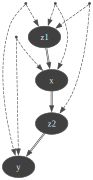

In [17]:
m1 = gum.fastBN("z1->x->z2->y")

cdg = csl.CausalModel(m1, [("Z1−X",["z1","x"]),
                           ("Z1-Y",["z1","y"]),
                           ("Z1-Z1",["z1","z2"]), 
                           ("X−Y",["x","y"])
                          ], True )
cslnb.showCausalModel(cdg)

In [18]:
err = cslnb.showCausalImpact(cdg,"y","x",values={"x":0})


## another one

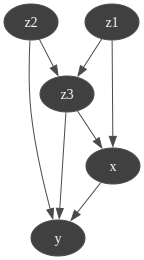

In [19]:
# EXEMPLE PAGE 17 : http://ftp.cs.ucla.edu/pub/stat_ser/r350.pdf


m1 = gum.BayesNet()
m1.add(gum.LabelizedVariable("x"))
m1.add(gum.LabelizedVariable("y"))
m1.add(gum.LabelizedVariable("z1"))
m1.add(gum.LabelizedVariable("z2"))
m1.add(gum.LabelizedVariable("z3"))

m1.addArc(2,4)
m1.addArc(2,0)
m1.addArc(3,4)
m1.addArc(3,1)
m1.addArc(4,1)
m1.addArc(4,0)
m1.addArc(0,1)

gnb.showBN(m1)
d = csl.CausalModel(m1)

In [20]:
display(Math(csl.identifyingIntervention (d,{"z1","z2","z3","y"}, {"x"}).toLatex()))

<IPython.core.display.Math object>

In [21]:
display(Math(csl.identifyingIntervention(d,{"y"}, {"x"}).toLatex()))

<IPython.core.display.Math object>

In [22]:
display(Math(csl.identifyingIntervention(d,{"z1","z3","y"}, {"x","z2"}).toLatex()))

<IPython.core.display.Math object>

In [23]:
display(Math(csl.identifyingIntervention(d,{"y"}, {"x","z2"}).toLatex()))

<IPython.core.display.Math object>

## Other example

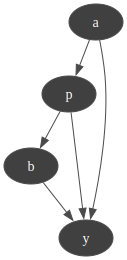

In [24]:
#http://www.stats.ox.ac.uk/~lienart/gml15_causalinference.html

m1 = gum.BayesNet()
m1.add(gum.LabelizedVariable("a"))
m1.add(gum.LabelizedVariable("p"))
m1.add(gum.LabelizedVariable("b"))
m1.add(gum.LabelizedVariable("y"))

m1.addArc(0,1)
m1.addArc(1,2)
m1.addArc(0,3)
m1.addArc(1,3)
m1.addArc(2,3)
gnb.showBN(m1)
d = csl.CausalModel(m1)

In [25]:
display(Math(csl.identifyingIntervention(d,{"y"}, {"a","b"}).toLatex()))

<IPython.core.display.Math object>

## example f

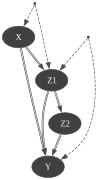

In [26]:
#https://cse.sc.edu/~mgv/talks/AIM2010.ppt , example (f)

m1 = gum.BayesNet()
m1.add(gum.LabelizedVariable("X"))
m1.add(gum.LabelizedVariable("Y"))
m1.add(gum.LabelizedVariable("Z1"))
m1.add(gum.LabelizedVariable("Z2"))

m1.addArc(0,1)
m1.addArc(0,2)
m1.addArc(2,3)
m1.addArc(3,1)
m1.addArc(2,1)
d = csl.CausalModel(m1, [("l1",["X","Z1"]) ,("l2",["Y","Z1"])],True)
cslnb.showCausalModel(d)

In [27]:
try:
    display(Math(csl.identifyingIntervention (d,{"Y"}, {"X"}).toLatex()))
except csl.HedgeException as e:
    print("Hedge exception : {}".format(e))

Hedge exception : Hedge Error: G={'Y', 'Z1', 'X'}, G[S]={'Z1', 'Y'}


## Example [Pearl,2009] Causality, p66

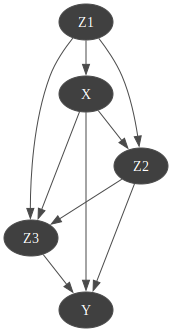

In [28]:
bn = gum.fastBN("Z1->Z2->Z3->Y<-X->Z2;Z2->Y;Z1->X->Z3<-Z1")
gnb.showBN(bn)

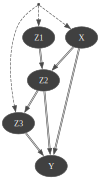

In [29]:
c = csl.CausalModel(bn, [("Z0", ("X", "Z1", "Z3"))], False)
cslnb.showCausalModel(c)

In [30]:
formula, impact, explanation = csl.causalImpact(c, "Y", "X")
cslnb.showCausalImpact(c,"Y","X")